# Generating synthetic faces using a variational autoencoder, VAE
In this notebook a variational autoencoder will be implemented and trained using the "CelebA" dataset from kaggle. There will note be any mathematical proof here but the math can be found fairly easily.

A variational autoencoder consists of two main parts, a decoder, and an encoder. The role of the encoder is to take data and reduce the dimension in order to be able to represent it in a lower dimensional space, similar to what PCA does. The decoder is then trained to take data from this lower dimension and reconstruct it back to the higher dimension. Thereby the input to the encoder is data of dimension X while the ouput has the dimension x, which is smaller. The input to the encoder then has teh dimension x while the output of the decoder has the dimension X hence feeding an image through the encoder and then the decoder shouyld ideally result in the same image, though reconstruction losses will make the output slightly different as well see.

In [1]:
import os
from glob import glob
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from keras.losses import binary_crossentropy,mse

Using TensorFlow backend.


Since this project is about a variational autoencoder, which works with distributions, we will not decode the data into a sincle vector i.e. going from an input size of 100 down to a size of 10. Instead the encoding will be done to two vectors, one for the mean of the distribution and one for the variance.  

In [2]:
def dynamic_encoder(input_dim, output_dim, nr_filters, kernel_sizes, conv_strides, 
            batch_normalize = False, use_dropout = False):
    
    global K
    K.clear_session()
    
    nr_layers = len(nr_filters)
    
    inputs = Input(shape = input_dim, name = 'encoder_input') 
    x = inputs #Input layer
    
    #In the following loop we add blocks of layers on the form Conv2D followed by Batch normalization, Activation layer and
    #finally a dropout layer, though batch normalization and dropout is optional.
    
    for i in range(nr_layers):
        x = Conv2D(filters = nr_filters[i], kernel_size = kernel_sizes[i],
                  strides = conv_strides[i], padding = 'same',
                  name = 'encoder_layer_' + str(i))(x)
        
        if batch_normalize:
            x = BatchNormalization()(X)
        x = LeakyReLU()(x)
        
        if use_dropout:
            x = Dropout(rate = 0.25)(x)
            
    non_flatten_shape = K.int_shape(x)[1:] #Getting the dimensions of the tensor before flattening it in order to later be able to get images.

    x = Flatten()(x)
    
    mu = Dense(output_dim, name = 'mu')(x) #Adding a layer to get the mean of the distributions of the latent vector
    log_var = Dense(output_dim, name = 'log_var')(x) #Adding a layer to get the variance of the distributions of the latent vector

    #In this case we perform the sampling in the encoder model 
    def sampling(args):
        mu, log_var = args
        epsilon = K.random_normal(shape = K.shape(mu), mean = 0., stddev = 1.)
        return mu + K.exp(log_var/2)*epsilon
    
    output = Lambda(sampling, name = 'encoder_output')([mu, log_var]) #Output layer of the encoder which uses the Lamda layer that samples from mu and log_var
    
    return mu, log_var, inputs, output, non_flatten_shape, Model(inputs, [mu, log_var, output], name = 'Encoder')

The decoder will be made in the same way as the encoder however we just returns the output of the decoder and the decoder model itself.

In [3]:
def dynamic_decoder(input_dim, non_flatten_shape, nr_filters, kernel_sizes,
                   conv_strides):
    
    nr_layers = len(nr_filters)
    
    inputs = Input(shape = (input_dim,), name = 'decoder_input')
    
    x = Dense(np.prod(non_flatten_shape))(inputs)
    x = Reshape(non_flatten_shape)(x)
    
    for i in range(nr_layers):
        x = Conv2DTranspose(filters = nr_filters[i], kernel_size = kernel_sizes[i],
                           strides = conv_strides[i], padding = 'same',
                           name = 'decoder_layer_' + str(i))(x)
        
        if i < nr_layers - 1:
            x = LeakyReLU()(x)
        else:
            x = Activation('sigmoid')(x)
            
    output = x
    
    return output, Model(inputs, output, name = 'Decoder')

To look at how the model performs we'll implement to functions to plot images. The first, "compare_iamges" feeds images to the model and shows the predicted, reconstructed output of the model while the second generates completely new images by using the decoder on values sampled from a normal distribution.

In [4]:
def compare_images(images, model):
    nr_images = images.shape[0]
    reconstructed = model.predict(images)
    
    fig = plt.figure(figsize = (15,3))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    
    for i in range(nr_images):
        img  = images[i].squeeze()
        sub = fig.add_subplot(2, nr_images, i + 1)
        sub.axis('off')
        sub.imshow(img)
        
    for i in range(nr_images):
        img  = reconstructed[i].squeeze()
        sub = fig.add_subplot(2, nr_images, i + nr_images + 1)
        sub.axis('off')
        sub.imshow(img)

In [5]:
def generate_images(model, latent_space, nr_images = 10):
    generated = model.predict(np.random.normal(0, 1, size = (nr_images, latent_space)))
    
    fig = plt.figure(figsize = (15, 3))
    fig.subplots_adjust(hspace = 0.4, wspace = 0.4)
    
    for i in range(nr_images):
        img = generated[i].squeeze()
        sub = fig.add_subplot(2, nr_images, i + 1)
        sub.axis('off')
        sub.imshow(img)

The main function below is what will drive the whole code. What basically happens is that the encoder and decoder is created whereby they get connected into a vae model which then gets trained. During the training a special loss function is used. This loss function consists of two parts one is the reconstruction loss which meassures how close the reconstruction, output, is to the input. The second part is the so called Kullback-Leibler Divergence which basically meassures how well different distributions fit each others. Another quirk of this project is that we'll use the flow_from_director

In [6]:
def main():
    height = 128
    width = 128
    nr_channels = 3
    
    batch_size = 512
    learning_rate = 0.0005
    epochs = 150
    
    latent_vector = 200
    image_dim = (height, width, nr_channels)
    
    encoder_filters = [32, 64, 64, 64]
    decoder_filters = [64, 64, 32, 3]
    kernels = [3, 3, 3, 3]
    strides = [2, 2, 2, 2]
    
    current_folder = os.getcwd()
    data_folder = current_folder + '/data/img_align_celeba/'

    filenames = os.listdir(data_folder)
    nr_images = len(filenames)
    print("Total number of images : " + str(nr_images))
    
    data_folder = current_folder + '/data/'

    data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(data_folder, 
                                                                       target_size = image_dim[:2],
                                                                       batch_size = batch_size,
                                                                       shuffle = True,
                                                                       class_mode = 'input',
                                                                       subset = 'training'
                                                                       )
    
    
    mu, log_var, encoder_in, encoder_out, shape, encoder = dynamic_encoder(image_dim, latent_vector, encoder_filters, kernels, strides) 
    decoder_output, decoder = dynamic_decoder(latent_vector, shape, decoder_filters, kernels, strides)
    
    vae_output = decoder(encoder(encoder_in)[2])
    vae = Model(encoder_in, vae_output)
    def kl_reconstruction_loss(true, pred):
      # Reconstruction loss
        reconstruction_loss = binary_crossentropy(K.flatten(true), K.flatten(pred)) * 128 * 128
      # KL divergence loss
        kl_loss = 1 + log_var - K.square(mu) - K.exp(log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
      # Total loss = 50% rec + 50% KL divergence loss
        return K.mean(reconstruction_loss + kl_loss)

    vae.compile(optimizer='adam', loss = kl_reconstruction_loss)
    vae.summary()
    callbacks = [ModelCheckpoint('trained_vae.h5', verbose = 1, save_best_only = True, monitor = 'loss')]
    vae.fit(data_flow, 
                        shuffle = True, 
                        epochs = epochs, 
                        callbacks = callbacks,
                        initial_epoch = 0, 
                        steps_per_epoch = nr_images / batch_size
                        )
    examples = next(data_flow)
    examples  = examples[0]
    examples_images = examples[:10]
    print("Comparison of original image and reconstructed image after passing through encoder/decoder" )
    compare_images(examples_images, vae)
    
    print("Newly generated faces.")
    generate_images(decoder, latent_vector)
    

Total number of images : 202599
Found 202599 images belonging to 1 classes.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
Encoder (Model)              [(None, 200), (None, 200) 1732048   
_________________________________________________________________
Decoder (Model)              (None, 128, 128, 3)       916483    
Total params: 2,648,531
Trainable params: 2,648,531
Non-trainable params: 0
_________________________________________________________________
Epoch 1/150
396/395 [==============================] - 263s 664ms/step - loss: 8993.5267

Epoch 00001: loss improved from inf to 8993.68350, saving model to trained_vae.h5
Epoch 2/150
396/395 [==============================] - 216s 544ms/step - loss: 8424.2638

Epoch 00002: loss improved from 8993.6835

396/395 [==============================] - 198s 501ms/step - loss: 8233.5812

Epoch 00042: loss improved from 8233.89693 to 8233.45652, saving model to trained_vae.h5
Epoch 43/150
396/395 [==============================] - 198s 500ms/step - loss: 8233.0432

Epoch 00043: loss improved from 8233.45652 to 8233.06390, saving model to trained_vae.h5
Epoch 44/150
396/395 [==============================] - 197s 497ms/step - loss: 8232.9541

Epoch 00044: loss improved from 8233.06390 to 8232.93002, saving model to trained_vae.h5
Epoch 45/150
396/395 [==============================] - 198s 501ms/step - loss: 8232.4306

Epoch 00045: loss improved from 8232.93002 to 8232.45284, saving model to trained_vae.h5
Epoch 46/150
396/395 [==============================] - 198s 500ms/step - loss: 8232.0914

Epoch 00046: loss improved from 8232.45284 to 8232.12980, saving model to trained_vae.h5
Epoch 47/150
396/395 [==============================] - 198s 500ms/step - loss: 8231.9071

Epoch 00047: loss impr

396/395 [==============================] - 198s 501ms/step - loss: 8224.2237

Epoch 00090: loss did not improve from 8224.23998
Epoch 91/150
396/395 [==============================] - 199s 502ms/step - loss: 8224.3680

Epoch 00091: loss did not improve from 8224.23998
Epoch 92/150
396/395 [==============================] - 197s 497ms/step - loss: 8224.0225

Epoch 00092: loss improved from 8224.23998 to 8224.03187, saving model to trained_vae.h5
Epoch 93/150
396/395 [==============================] - 201s 507ms/step - loss: 8223.9314

Epoch 00093: loss improved from 8224.03187 to 8223.90192, saving model to trained_vae.h5
Epoch 94/150
396/395 [==============================] - 201s 508ms/step - loss: 8224.0908

Epoch 00094: loss did not improve from 8223.90192
Epoch 95/150
396/395 [==============================] - 201s 507ms/step - loss: 8224.0088

Epoch 00095: loss did not improve from 8223.90192
Epoch 96/150
396/395 [==============================] - 197s 499ms/step - loss: 8223.6890

396/395 [==============================] - 200s 504ms/step - loss: 8221.2203

Epoch 00142: loss did not improve from 8221.19723
Epoch 143/150
396/395 [==============================] - 200s 504ms/step - loss: 8221.2169

Epoch 00143: loss improved from 8221.19723 to 8221.17505, saving model to trained_vae.h5
Epoch 144/150
396/395 [==============================] - 198s 501ms/step - loss: 8220.8157

Epoch 00144: loss improved from 8221.17505 to 8220.90886, saving model to trained_vae.h5
Epoch 145/150
396/395 [==============================] - 199s 502ms/step - loss: 8220.8617

Epoch 00145: loss improved from 8220.90886 to 8220.83406, saving model to trained_vae.h5
Epoch 146/150
396/395 [==============================] - 200s 505ms/step - loss: 8220.8971

Epoch 00146: loss did not improve from 8220.83406
Epoch 147/150
396/395 [==============================] - 199s 503ms/step - loss: 8220.6015

Epoch 00147: loss improved from 8220.83406 to 8220.67063, saving model to trained_vae.h5
Epoch 

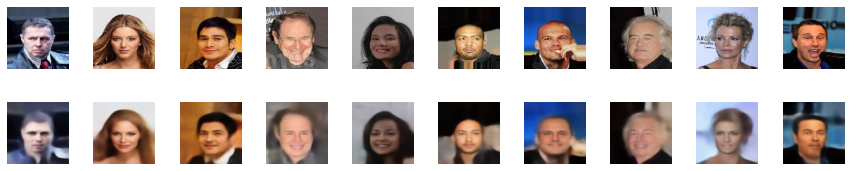

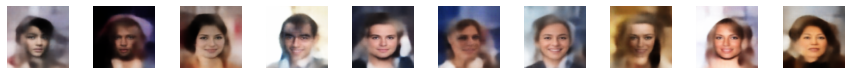

In [7]:
main()

So as we can see the vae model manages to reconstruct the faces fairly well. They are blurier so in the second image from the left we can't make out any details in the hair and the fourth image looks different other examples are the fourth from the right which in the original image had his face obstructed while in the reconstruction the obstruction is not there. 

As For the fake faces they all look like facesonce again everything other than the face is blurry but this is to be expected since we probably can assume that the background of the original images will vary a lot. What we can say howver is that the model can generate male and female faces of different ethnicities and with different facial angles.